In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.functional as F
import torch
import torch.optim as optim

%load_ext autoreload
%autoreload 2

from training import Trainer
from load_data import LFWDataLoader

C:\Users\rwbak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rwbak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [214]:
dl = LFWDataLoader(batch_size=24)

train_dl = dl.train_dataloader
train_vanilla_dl = dl.train_vanilla_dataloader
val_dl = dl.val_dataloader
test_dl = dl.test_dataloader

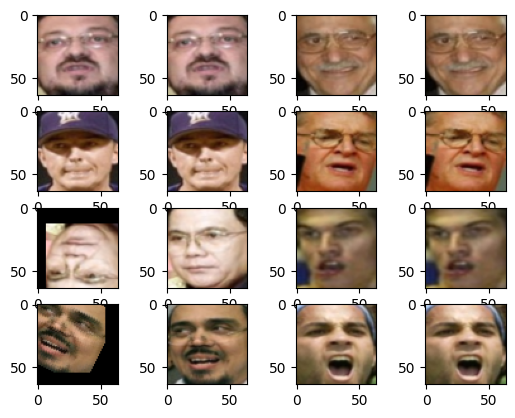

In [216]:
f = plt.figure()
for i in range(8):
    data, label = next(iter(train_dl))
    f.add_subplot(4,4,2*i+1)
    plt.imshow(data[0].to('cpu').permute(1, 2, 0))
    f.add_subplot(4,4,2*i+2)
    plt.imshow(label[0].to('cpu').permute(1, 2, 0))

In [369]:
from model import *
from loss import LogCoshLoss, PerceptualLoss

latent = 20
hidden = 100

model = AutoEncoder(NewEncoder(latent),NewDecoder(latent))
print('PARAMETERS: ',sum(p.numel() for p in model.parameters() if p.requires_grad))
print()

optim = torch.optim.Adam(model.parameters(), lr=1e-4)
# optim = torch.optim.Adagrad(model.to(device).parameters(),lr=1e-3,weight_decay=0.97)

trainer = Trainer(model, optim, device, train_vanilla_dl, val_dl, lossfn=nn.BCELoss(reduction='sum'))
torch.cuda.empty_cache()
mse, kl, total = trainer.train_model(epochs=25,print_every=1000)

PARAMETERS:  36396971

EPOCH:  0
Iteration 0, loss = 206886.8594
KL DIV: 0.0714
Recon Loss: 206886.7812

Avg Recon Loss on Val: 203365.75

EPOCH:  1
Iteration 0, loss = 186167.7812
KL DIV: 501.5422
Recon Loss: 185666.2344

Avg Recon Loss on Val: 183062.57142857142

EPOCH:  2
Iteration 0, loss = 186422.8594
KL DIV: 540.1923
Recon Loss: 185882.6719

Avg Recon Loss on Val: 180466.48214285713

EPOCH:  3
Iteration 0, loss = 184923.4531
KL DIV: 691.5829
Recon Loss: 184231.8750

Avg Recon Loss on Val: 179463.69642857142

EPOCH:  4
Iteration 0, loss = 185330.8750
KL DIV: 627.8472
Recon Loss: 184703.0312

Avg Recon Loss on Val: 178938.8392857143

EPOCH:  5
Iteration 0, loss = 183312.6094
KL DIV: 790.4966
Recon Loss: 182522.1094

Avg Recon Loss on Val: 178526.3392857143

EPOCH:  6
Iteration 0, loss = 181224.1719
KL DIV: 836.2157
Recon Loss: 180387.9531

Avg Recon Loss on Val: 178115.9642857143

EPOCH:  7
Iteration 0, loss = 181756.6562
KL DIV: 766.7806
Recon Loss: 180989.8750

Avg Recon Loss on 

In [370]:
trainer.check_accuracy(loader=test_dl,model=model)

Avg Recon Loss on Val: 176792.98214285713


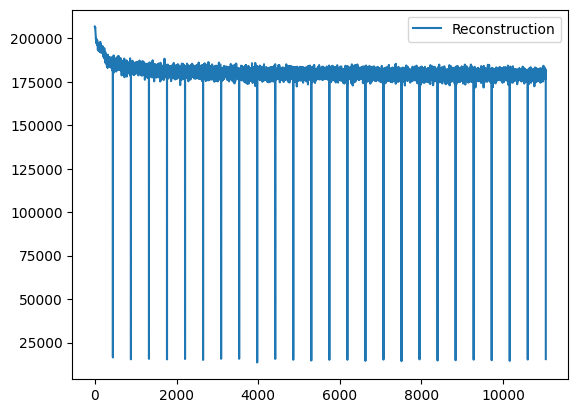

In [371]:
plt.plot(range(len(mse)),mse,label='Reconstruction')
plt.legend()

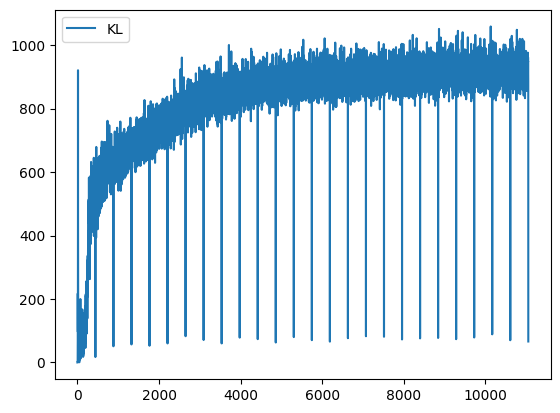

In [372]:
plt.plot(range(len(kl)),kl,label='KL')
plt.legend()

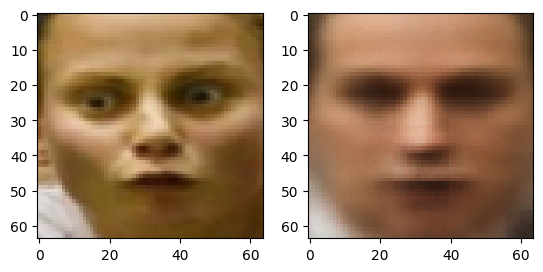

In [379]:
f = plt.figure()
tensor_image,_ = next(iter(test_dl))
f.add_subplot(1,2,1)
plt.imshow(tensor_image[0].permute(1, 2, 0))
model.eval()
with torch.no_grad():
    tensor_image = tensor_image[0].unsqueeze(0)
    scores,_ = model(tensor_image.to(device))

f.add_subplot(1,2,2)
scores = scores.squeeze(0)
plt.imshow(scores.to('cpu').permute(1, 2, 0))

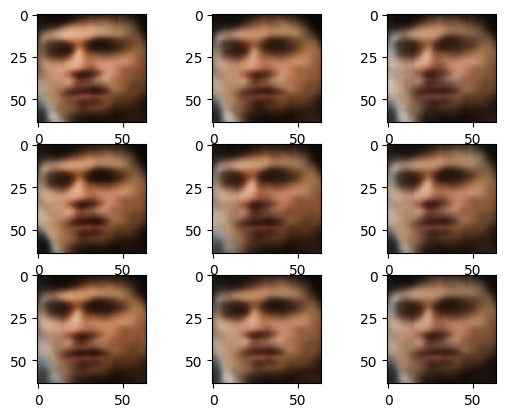

In [374]:
encoder = model.encoder
decoder = model.decoder
idx = np.random.randint(0,1000)
tensor_image,_ = next(iter(test_dl))
tensor_image = tensor_image[0].unsqueeze(0)
with torch.no_grad():
    latent_mu,latent_var = encoder(tensor_image.to(device))
latent_var = latent_var.to('cpu').detach()
latent_mu = latent_mu.to('cpu').detach()
with torch.no_grad():
    randomData = torch.Tensor(np.random.normal(latent_mu,3*np.exp(0.5*latent_var),(9,latent)))
    scores = model.decoder(randomData.to(device))
f = plt.figure()
for i in range(9):
    f.add_subplot(3,3,i+1)
    plt.imshow(scores[i].squeeze(0).to('cpu').permute(1, 2, 0))

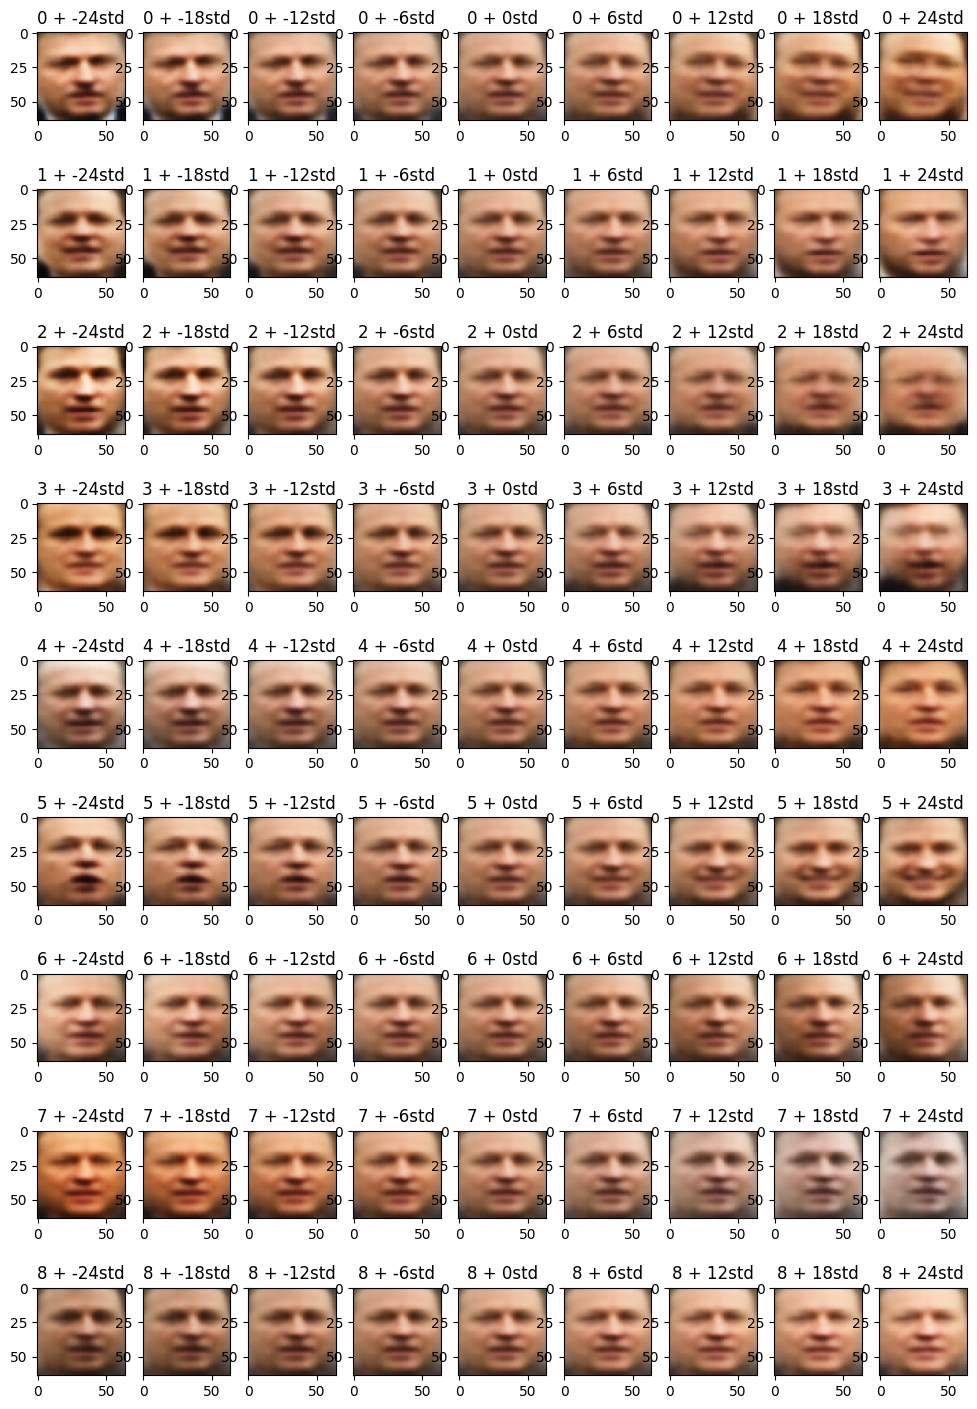

In [375]:
encoder = model.encoder
decoder = model.decoder

num_latents = 9
latent_offset = 0
f = plt.figure(figsize=(12,18))

# Get latent space of random image
tensor_image,_ = next(iter(test_dl))
tensor_image = tensor_image[0].unsqueeze(0)
with torch.no_grad():
    latent_mu,latent_var = encoder(tensor_image.to(device))
latent_var = latent_var.to('cpu').detach()
latent_mu = latent_mu.to('cpu').detach()

#Get different num standard deviations from mu
add = torch.arange(-4,5)*6

#for each of N latent spaces iterate thru stdevs
for latent_i in range(num_latents):
    for i in range(9):
        #generate new faces with each stdev
        randomData = latent_mu.clone().detach()
        with torch.no_grad():
            randomData[0][latent_i + latent_offset] = latent_mu[0][latent_i + latent_offset] + add[i] * torch.exp(0.5*latent_var[0][latent_i + latent_offset])
            scores = model.decoder(randomData.to(device))
        #plot it
        f.add_subplot(num_latents,9,(9*latent_i) + i+1)
        plt.imshow(scores[0].squeeze(0).to('cpu').permute(1, 2, 0))
        plt.title('{} + {}std'.format(latent_i + latent_offset,add[i]))

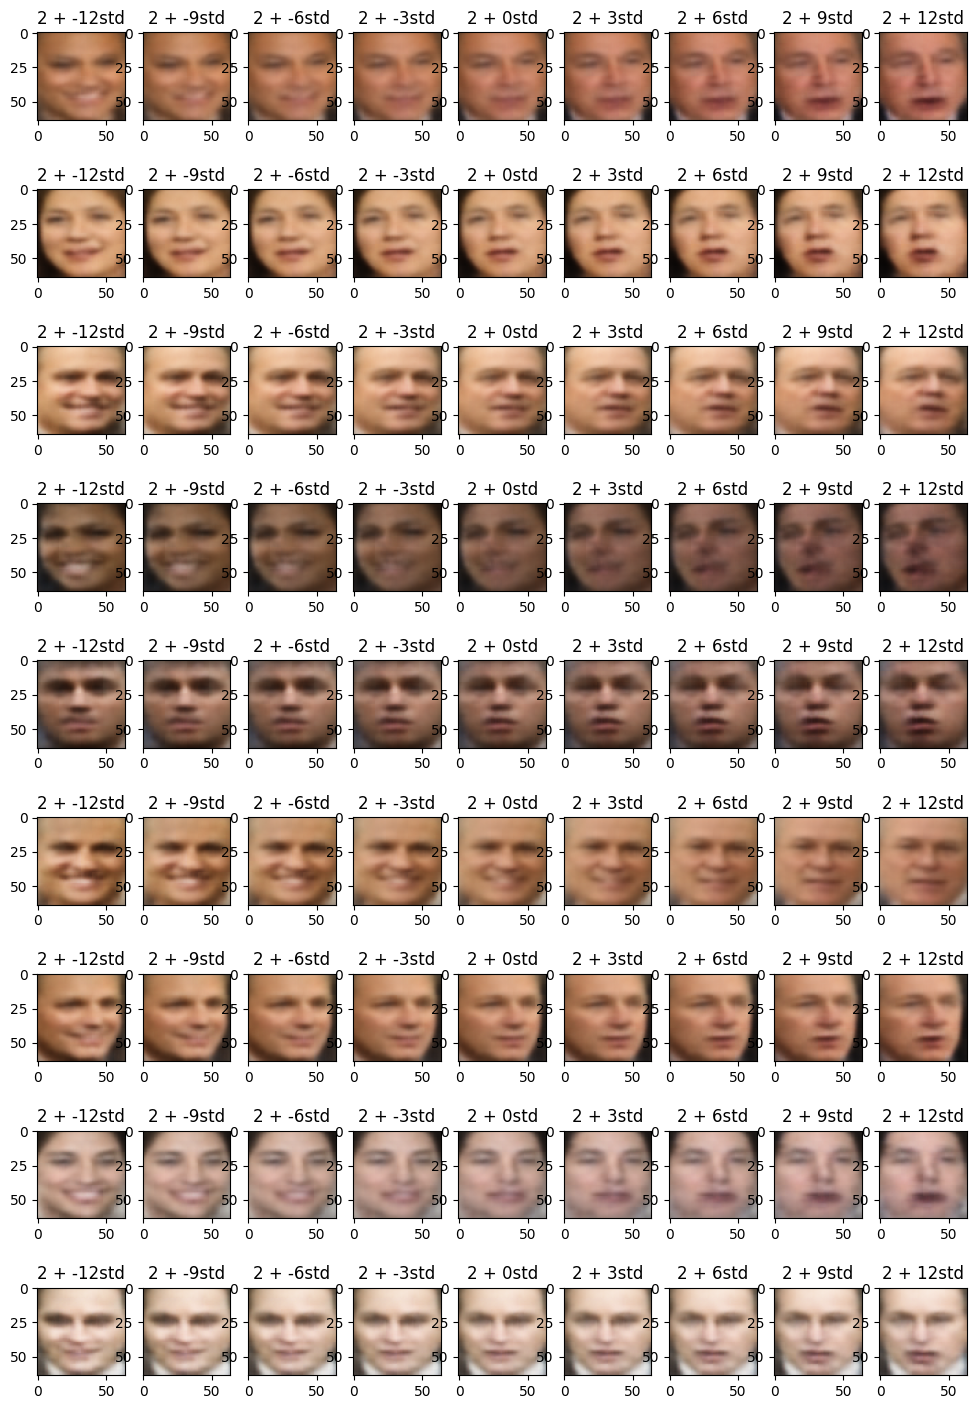

In [307]:
encoder = model.encoder
decoder = model.decoder

num_img = 9
latent_offset = 0
f = plt.figure(figsize=(12,18))

# Get latent space of random image
tensor_image,_ = next(iter(test_dl))
tensor_image = tensor_image[:num_img]
with torch.no_grad():
    latent_mu,latent_var = encoder(tensor_image.to(device))
latent_var = latent_var.to('cpu').detach()
latent_mu = latent_mu.to('cpu').detach()

#Get different num standard deviations from mu
add = torch.arange(-4,5)*3

#for each of N latent spaces iterate thru stdevs
for img in range(9):
    for i in range(9):
        #generate new faces with each stdev
        randomData = latent_mu.clone().detach()
        with torch.no_grad():
            randomData[img][2] = latent_mu[img][2] + add[i] * torch.exp(0.5*latent_var[img][2])
            scores = model.decoder(randomData.to(device))
        #plot it
        f.add_subplot(num_latents,9,(9*img) + i+1)
        plt.imshow(scores[img].squeeze(0).to('cpu').permute(1, 2, 0))
        plt.title('{} + {}std'.format(latent_i + latent_offset,add[i]))

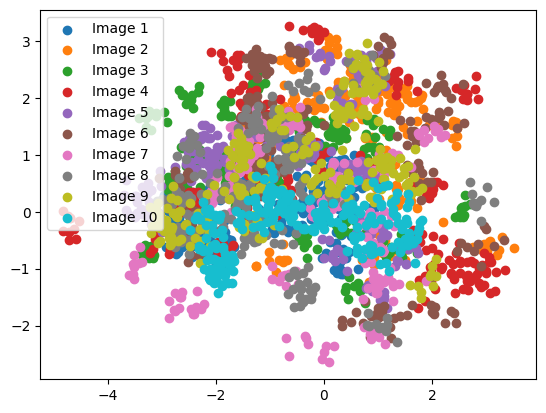

In [376]:
import torchvision.transforms as T

encoder = model.encoder

train_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((64,64)),
    T.RandomAffine(degrees = 0, translate = (0.25, 0.25)),
    T.ToTensor()
])

img,_ = next(iter(test_dl))

for i in range(10):
    plot1,plot2 = [],[]
    for j in range(24):
        tensor_image = train_transform(img[i])
        with torch.no_grad():
            latent_mu,latent_var = encoder(tensor_image.to(device).unsqueeze(0))
        latent_var = latent_var.to('cpu').detach()
        latent_mu = latent_mu.to('cpu').detach()
        latent_dist = torch.distributions.Normal(latent_mu[0,0],torch.exp(0.5*latent_var[0,0]))
        latent_dist_2 = torch.distributions.Normal(latent_mu[0,1],torch.exp(0.5*latent_var[0,1]))
        for x in range(10):
            plot1.append(latent_dist.rsample())
            plot2.append(latent_dist_2.rsample())
    plt.scatter(plot1,plot2)
    plt.legend([
        'Image 1',
        'Image 2',
        'Image 3',
        'Image 4',
        'Image 5',
        'Image 6',
        'Image 7',
        'Image 8',
        'Image 9',
        'Image 10',
    ])

In [224]:
torch.save(model,'100_epoch_20_latent_more_transform.model')

In [289]:
model = torch.load('100_epoch_20_latent_more_transform.model')

In [113]:
import gc 
model = 1
del model 
gc.collect()
plt.close()
with torch.no_grad():
    torch.cuda.empty_cache()